In [1]:
import pandas as pd 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from datetime import datetime
%matplotlib inline 

In [2]:
# load dataframe
dfs = pd.read_excel("Adventure Works_Database.xlsx",sheet_name="Sheet3", engine="openpyxl")
print(dfs.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CustomerKey           18484 non-null  int64         
 1   FirstName             18484 non-null  object        
 2   LastName              18484 non-null  object        
 3   FullName              18484 non-null  object        
 4   BirthDate             18484 non-null  datetime64[ns]
 5   MaritalStatus         18484 non-null  object        
 6   Gender                18484 non-null  object        
 7   YearlyIncome          18484 non-null  int64         
 8   TotalChildren         18484 non-null  int64         
 9   NumberChildrenAtHome  18484 non-null  int64         
 10  Education             18484 non-null  object        
 11  Occupation            18484 non-null  object        
 12  HouseOwnerFlag        18484 non-null  int64         
 13  NumberCarsOwned 

In [3]:
dfs['Gender'] = dfs['Gender'].astype('category')
dfs['MaritalStatus'] = dfs['MaritalStatus'].astype('category')
dfs['Education'] = dfs['Education'].astype('category')
dfs['Occupation'] = dfs['Occupation'].astype('category')
dfs['CommuteDistance'] = dfs['CommuteDistance'].astype('category')
cat_columns = dfs.select_dtypes(['category']).columns
dfs[cat_columns] = dfs[cat_columns].apply(lambda x: x.cat.codes)
df = dfs.select_dtypes(exclude=['object'])
df=df.dropna()
df['AgeFirstPurchase']=(df['DateFirstPurchase'].dt.year-df['BirthDate'].dt.year).astype(int)
df['BirthDate']=df[['BirthDate']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
df['DateFirstPurchase']=df[['DateFirstPurchase']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
df.head()



,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,AgeFirstPurchase
0,11000,-117849600,0,1,90000,2,0,0,3,1,0,1390348800,1,48
1,11001,-146275200,1,1,60000,3,3,0,3,0,1,1390003200,0,49
2,11002,-138499200,0,1,60000,3,3,0,3,1,1,1389312000,3,49
3,11003,-59270400,1,0,70000,0,0,0,3,0,1,1388534400,4,46
4,11004,-44150400,1,0,80000,5,5,0,3,1,4,1390694400,1,46


In [4]:
obsolete_columns = [
    'CustomerKey',
    'BirthDate',
    'DateFirstPurchase'
]
df.drop(columns=obsolete_columns, inplace=True)
df.head()

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,CommuteDistance,AgeFirstPurchase
0,0,1,90000,2,0,0,3,1,0,1,48
1,1,1,60000,3,3,0,3,0,1,0,49
2,0,1,60000,3,3,0,3,1,1,3,49
3,1,0,70000,0,0,0,3,0,1,4,46
4,1,0,80000,5,5,0,3,1,4,1,46


In [113]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17918 entries, 0 to 18483
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   MaritalStatus         17918 non-null  int8 
 1   Gender                17918 non-null  int8 
 2   YearlyIncome          17918 non-null  int64
 3   TotalChildren         17918 non-null  int64
 4   NumberChildrenAtHome  17918 non-null  int64
 5   Education             17918 non-null  int8 
 6   Occupation            17918 non-null  int8 
 7   HouseOwnerFlag        17918 non-null  int64
 8   NumberCarsOwned       17918 non-null  int64
 9   CommuteDistance       17918 non-null  int8 
 10  AgeFirstPurchase      17918 non-null  int32
dtypes: int32(1), int64(5), int8(5)
memory usage: 997.4 KB
None


In [114]:
df.describe()

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,CommuteDistance,AgeFirstPurchase
count,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000,17918.000000
mean,0.458198,0.506586,57341.221118,1.834133,1.001228,1.686070,2.308014,0.676192,1.496819,1.662016,53.942516
std,0.498263,0.499971,32279.351991,1.608377,1.520928,1.361843,1.411944,0.467941,1.138000,1.517202,11.279175
min,0.000000,0.000000,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000
25%,0.000000,0.000000,30000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,45.000000
50%,0.000000,1.000000,60000.000000,2.000000,0.000000,2.000000,3.000000,1.000000,2.000000,1.000000,52.000000
75%,1.000000,1.000000,70000.000000,3.000000,2.000000,3.000000,3.000000,1.000000,2.000000,3.000000,61.000000
max,1.000000,1.000000,170000.000000,5.000000,5.000000,4.000000,4.000000,1.000000,4.000000,4.000000,106.000000


In [135]:
df_norm=df.copy()
names = df.columns
min_max_scaler = preprocessing.MinMaxScaler()
df_norm = pd.DataFrame(min_max_scaler.fit_transform(df), columns=names)
df_norm

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,CommuteDistance,AgeFirstPurchase
0,0.0,1.0,0.5000,0.4,0.0,0.00,0.75,1.0,0.00,0.25,0.194444
1,1.0,1.0,0.3125,0.6,0.6,0.00,0.75,0.0,0.25,0.00,0.208333
2,0.0,1.0,0.3125,0.6,0.6,0.00,0.75,1.0,0.25,0.75,0.208333
3,1.0,0.0,0.3750,0.0,0.0,0.00,0.75,0.0,0.25,1.00,0.166667
4,1.0,0.0,0.4375,1.0,1.0,0.00,0.75,1.0,1.00,0.25,0.166667
...,...,...,...,...,...,...,...,...,...,...,...
17913,0.0,1.0,0.1250,0.2,0.0,0.25,0.00,1.0,0.00,0.00,0.319444
17914,1.0,0.0,0.1250,0.6,0.0,0.25,0.00,1.0,0.00,0.00,0.305556
17915,1.0,1.0,0.1250,0.6,0.0,0.25,0.00,0.0,0.00,0.00,0.277778
17916,0.0,1.0,0.1250,0.6,0.0,0.00,0.00,1.0,0.00,0.00,0.305556


In [5]:
scaled_df=df.copy()
scaled_df[['YearlyIncome']] = preprocessing.StandardScaler().fit_transform(df[['YearlyIncome']])
scaled_df

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,CommuteDistance,AgeFirstPurchase
0,0,1,1.011783,2,0,0,3,1,0,1,48
1,1,1,0.082370,3,3,0,3,0,1,0,49
2,0,1,0.082370,3,3,0,3,1,1,3,49
3,1,0,0.392174,0,0,0,3,0,1,4,46
4,1,0,0.701979,5,5,0,3,1,4,1,46
...,...,...,...,...,...,...,...,...,...,...,...
18479,0,1,-0.847043,1,0,1,0,1,0,0,57
18480,1,0,-0.847043,3,0,1,0,1,0,0,56
18481,1,1,-0.847043,3,0,1,0,0,0,0,54
18482,0,1,-0.847043,3,0,0,0,1,0,0,56


In [6]:
# PCA
pca = PCA(n_components=2)
X=pca.fit_transform(scaled_df)
print(pca.explained_variance_ratio_)

[0.90680507 0.02679721]


In [7]:
X[:10]

array([[-5.94083408, -0.61036097],
       [-4.88727491,  1.75199584],
       [-4.82473395,  2.38730611],
       [-8.0376925 , -0.81248243],
       [-7.63438275,  5.76111245],
       [-5.04388214, -0.92763436],
       [-5.04384511, -0.92690372],
       [-3.85799574,  2.11304298],
       [-3.73764182,  4.02463038],
       [-4.05196023, -1.01527837]])

In [144]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

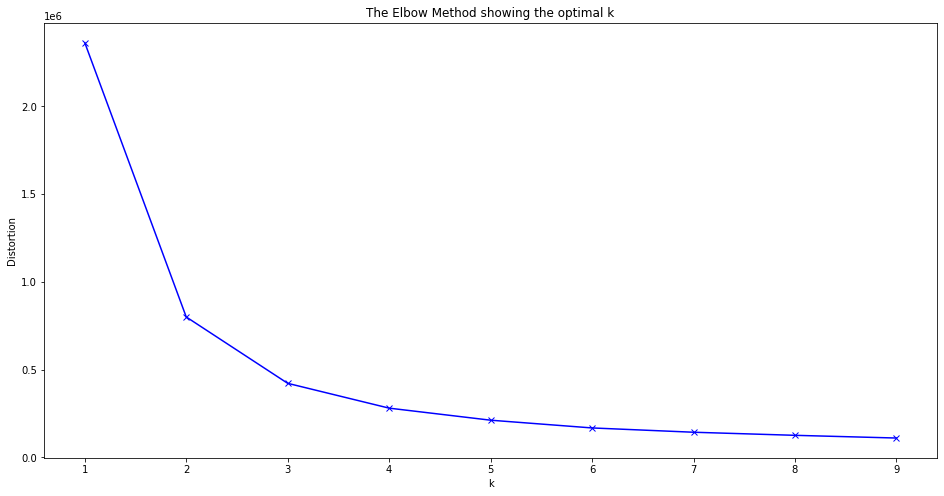

In [145]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [167]:
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(X)
X_cluster=kmeanModel.predict(X)
df_kmeans=pd.DataFrame(X, columns=['pc1','pc2'])
df_kmeans['cluster']=X_cluster+1
df_kmeans

,pc1,pc2,cluster
0,-5.940834,-0.610361,2
1,-4.887275,1.751996,2
2,-4.824734,2.387306,2
3,-8.037693,-0.812482,2
4,-7.634383,5.761112,2
...,...,...,...
17913,2.972538,-2.665653,1
17914,2.117442,-1.637865,1
17915,0.120000,-1.574691,1
17916,2.129390,-1.647044,1


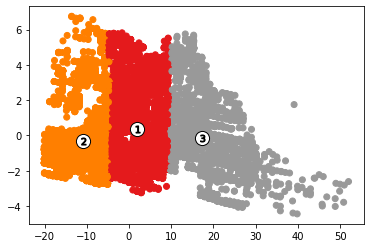

In [168]:
plt.scatter(df_kmeans['pc1'], df_kmeans['pc2'], c=df_kmeans['cluster'], cmap=plt.cm.Set1)
centers = kmeanModel.cluster_centers_
    # Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % (i+1), alpha=1,
                s=50, edgecolor='k')

plt.show()

In [8]:
for i,k in enumerate([2,3,4,5]):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    # Run the kmeans algorithm
    km = KMeans(n_clusters=k)
    y_predict = km.fit_predict(X)
    centroids  = km.cluster_centers_
# get silhouette
silhouette_vals = silhouette_samples(X,y_predict)
    #silhouette_vals
# silhouette plot
y_ticks = []
y_lower = y_upper = 0
for i,cluster in enumerate(np.unique(y_predict)):
   cluster_silhouette_vals = silhouette_vals[y_predict ==cluster]
   cluster_silhouette_vals.sort()
   y_upper += len(cluster_silhouette_vals)
   
   ax[0].barh(range(y_lower,y_upper),
   cluster_silhouette_vals,height =1);
   ax[0].text(-0.03,(y_lower+y_upper)/2,str(i+1))
   y_lower += len(cluster_silhouette_vals)
       
   # Get the average silhouette score 
   avg_score = np.mean(silhouette_vals)
   ax[0].axvline(avg_score,linestyle ='--',
   linewidth =2,color = 'green')
   ax[0].set_yticks([])
   ax[0].set_xlim([-0.1, 1])
   ax[0].set_xlabel('Silhouette coefficient values')
   ax[0].set_ylabel('Cluster labels')
   ax[0].set_title('Silhouette plot for the various clusters');
   # scatter plot of data colored with labels
   ax[1].scatter(X[:,0] ,X[:,1], c = y_predict);
   ax[1].scatter(centroids[:,0],centroids[:,1],
   marker = 'o' , c= 'r',s =250);
   ax[1].set_xlabel('Eruption time in mins')
   ax[1].set_ylabel('Waiting time to next eruption')
   ax[1].set_title('Visualization of clustered data', y=1.02)

   plt.tight_layout()
   plt.suptitle(f' Silhouette analysis using k = {k}',fontsize=16,fontweight = 'semibold')




MemoryError: Unable to allocate 1.00 GiB for an array with shape (7490, 17918) and data type float64